# SMA Trading Strategy


In [9]:
from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")

class SMABacktester():
    
    def __init__(self, ticker, start, end, SMA_short, SMA_long):
        self.ticker = ticker
        self.SMA_short = SMA_short
        self.SMA_long = SMA_long
        self.start = start
        self.end = end
        self.results = None
        self.get_data()
        self.prepare_data()

    def __repr__(self):
        return f"SMABacktester(ticker = {self.ticker} | SMA_short = {self.SMA_short} | SMA_long = {self.SMA_long} | start = {self.start} | end = {self.end})"

    def get_data(self):
        ''' Imports the data from the specified source
        '''
        data = pd.read_csv("forex_pairs.csv", parse_dates = ["Date"], index_col = "Date").dropna()
        data[self.ticker].to_frame().dropna()
        data = data.loc[self.start:self.end].copy()
        data.rename(columns = {self.ticker: "price"}, inplace = True)
        data["returns"] = np.log(data.price.div(data.price.shift(1)))
        self.data = data 

    def prepare_data(self):
        ''' Prepares the data for SMA trading strategy backtesting
        '''
        data = self.data.copy()
        data["SMA_short"] = data["price"].rolling(self.SMA_short).mean()
        data["SMA_long"] = data["price"].rolling(self.SMA_long).mean()
        self.data = data 

    def set_parameters(self, new_SMA_short = None, new_SMA_long = None):
        ''' Updates SMA parameters (SMA_short, SMA_long) and the prepared dataset
        '''
        if new_SMA_short is not None:
            self.SMA_short = new_SMA_short
            self.data["SMA_short"] = self.data["price"].rolling(self.SMA_short).mean()
            
        if new_SMA_long is not None:
            self.SMA_long = new_SMA_long
            self.data["SMA_long"] = self.data["price"].rolling(self.SMA_long).mean()

    def test_strategy(self):
        ''' Backtests the SMA-based trading strategy
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["SMA_short"] > data["SMA_long"], 1, -1)
        data["strategy"] = data.position.shift(1) * data["returns"]
        data.dropna(inplace = True)
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
       
        performance = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperformance = performance - data["creturns"].iloc[-1] # out-/underperformance of strategy compare to another one
        
        return round(performance, 6), round(outperformance, 6)
    
    def plot_results(self):
        ''' Plots the performance of the SMA trading strategy and compares to "buy and hold".
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = f"{self.ticker} | SMA short = {self.SMA_short} | SMA long = {self.SMA_long}"
            self.results[["creturns", "cstrategy"]].plot(title = title, figsize = (12, 8))     

    
    def optimize_parameters(self, SMA_short_range, SMA_long_range):
        ''' Finds the optimal strategy given the SMA parameters.

        Parameters
        ----------
        SMA_short_range, SMA_long_range: int
            tuples of the form (start, end, step size)        
        '''
        
        combinations = list(product(range(*SMA_short_range), range(*SMA_long_range)))
        
        # test all combinations
        results = []
        for combination in combinations:
            self.set_parameters(combination[0], combination[1])
            results.append(self.test_strategy()[0])
        
        best_performance = np.max(results) # best performance
        optimal_parameters = combinations[np.argmax(results)] # optimal parameters
        
        # set and run the optimal strategy
        self.set_parameters(optimal_parameters[0], optimal_parameters[1])
        self.test_strategy()
                   
        # create a dataframe with many results
        many_results =  pd.DataFrame(data = combinations, columns = ["SMA", "dev"])
        many_results["performance"] = results
        self.results_overview = many_results
                            
        return optimal_parameters, best_performance

In [10]:
tester2 = SMABacktester("EURUSD=X", "2004-01-01", "2020-06-30", 50, 200)

In [11]:
tester2

SMABacktester(ticker = EURUSD=X | SMA_short = 50 | SMA_long = 200 | start = 2004-01-01 | end = 2020-06-30)

In [12]:
tester2.plot_results()

Run test_strategy() first.


In [13]:
tester2.test_strategy()

(1.278635, 0.362809)

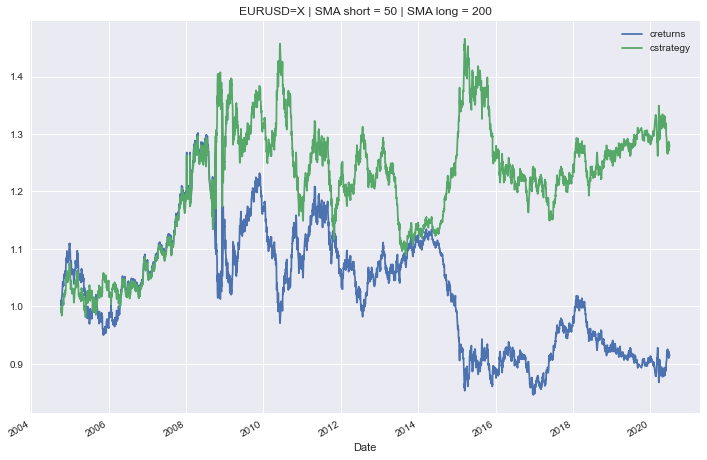

In [14]:
tester2.plot_results()
